## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from plotly.subplots import make_subplots
import plotly.graph_objects as go  
import math

import plotly.io as pio
pio.renderers.default= 'png'

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv('Project5_train_data.zip')
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])

In [4]:
taxi_data.describe(datetime_is_numeric=True)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-04-01 10:10:24.940037120,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,1.000000e+00,2016-01-01 00:00:17,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,2016-02-17 16:46:04.249999872,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,2016-04-01 17:19:40,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2016-05-15 03:56:08.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,2016-06-30 23:59:39,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,4.987772e-01,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


Данные представлены за период с 01.01.2016 по 30.06.2016.

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Пропусков в данных нет, то есть одной проблемой стало меньше.

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [6]:
print(taxi_data['vendor_id'].nunique())
print(taxi_data['trip_duration'].median())
taxi_data.describe()

2
662.0


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


В данных представлены поездки клиентов двух таксопарков, максимальное количество пассажиров в транспортном средстве - 9, медианная время поездки 662 сек., средняя время поездки - 959 сек. Минимальное время поездки - 1 сек. (что возможно является выбросом или поездка была отменена) а максимальное время поездки - 3526282 сек.(значение тоже вызывает сомнения(более 40 дней) и требует проверки - возможно водитель вовремя не отжал завершение поездки или не закончил смену).

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [4]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

add_datetime_features(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday


In [8]:
print(f'В субботу было совершено {taxi_data["pickup_day_of_week"].value_counts()["Saturday"]} поездок.')
print(f'В среднем в день совершалось {round(taxi_data["pickup_date"].value_counts().mean())} поездок.')

В субботу было совершено 220868 поездок.
В среднем в день совершалось 8015 поездок.


### Задание 2.5

От того, является ли день праздничным, часто зависит ситуация на дорогах. Большое количество автомобилей создаёт пробки и потенциально увеличивает длительность совершаемой на такси поездки.

Давайте добавим в наш датасет информацию о том, является ли день праздничным. Для этого мы собрали даты всех праздничных дней в Америке за 2016 год. [Данные](https://lms.skillfactory.ru/assets/courseware/v1/33bd8d5f6f2ba8d00e2ce66ed0a9f510/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/holiday_data.csv) представлены в табличном формате CSV и содержат три столбца:

- day — день недели;
- date — дата;
- holiday — наименование праздника.

Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [5]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')

def add_holiday_features(df_1, df_2):
    df_1['pickup_holiday'] = df_1.apply(lambda x: 1 if str(x.pickup_date) in list(df_2['date']) else 0, axis=1)
    return df_1
    
add_holiday_features(taxi_data, holiday_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0


In [10]:
print(f'Медианная длительность поездки в такси в праздничные дни равна {taxi_data[taxi_data["pickup_holiday"]==1]["trip_duration"].median()} сек.')

Медианная длительность поездки в такси в праздничные дни равна 585.0 сек.


Теперь, когда мы разобрались с временными характеристиками, переходим к географическим.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации.

Например, зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться **OSRM API**.

[**OSRM (Open Source Routing Machine)**](https://en.wikipedia.org/wiki/Open_Source_Routing_Machine) — это открытый бесплатный ресурс, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута. Он позволяет не только построить оптимальный кусочно-линейный путь из точки А в точку B, но также узнать его примерную длительность, длину, а также подробную информацию о количестве шагов, которые необходимо преодолеть по пути (количество поворотов). У данного сервиса есть API, с которым вы можете познакомиться в [документации](https://www.thinkdatascience.com/post/2020-03-03-osrm/osrm/).

Проблема заключается в том, что, так как в наших данных содержится информация о более чем одном миллионе поездок, подгрузка данных с помощью API и их предобработка может занять несколько часов, а при слабом интернет-соединении — и дней. Поэтому мы заранее подготовили выгрузку данных из OSRM API для каждой поездки из тренировочной и тестовой выборок нашего набора данных.

Файлы с данными из OSRM для поездок из тренировочной таблицы вы можете найти [здесь](https://drive.google.com/file/d/1ecWjor7Tn3HP7LEAm5a0B_wrIfdcVGwR/view?usp=sharing). Наборы данных представлены в табличном формате CSV. Нас будут интересовать только следующие столбцы:

- id — идентификатор поездки;
- total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
- total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
- number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [6]:
osrm_data = pd.read_csv('osrm_data_train.zip')

osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [7]:
osrm_data_cleaned = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

def add_osrm_features(df_1, df_2):
    df = df_1.merge(
        df_2,
        on='id',
        how='left'
    )
    return df

taxi_data = add_osrm_features(taxi_data, osrm_data_cleaned)

In [11]:
taxi_data.isnull().sum().tail(3)

total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64

In [12]:
taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()

372.5

В объединённом датасете имеем одно пропущенное значение - это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб-источника. Также видим, что медианная длительность поездки в данных больше медианной длительностью поездки, полученной из OSRM.

С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.

Немного теории ↓

Введём в наш анализ расстояние по [формуле Хаверсина](http://espressocode.top/haversine-formula-to-find-distance-between-two-points-on-a-sphere/). 

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

![An](https://lms.skillfactory.ru/assets/courseware/v1/27f8a26817acd0860b350a32d1287e5a/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-pr5_2_4.png)

Пусть есть две точки с географическими координатами $x_1 = (\varphi_1, \lambda_1)$ и $x_2 = (\varphi_2, \lambda_2)$, где

- $\varphi_1$ и $\lambda_1$ — широта (latitude) и долгота (longitude) первой точки маршрута (в радианах);
- $\varphi_12$ и $\lambda_2$ — широта (latitude) и долгота (longitude) второй точки маршрута (в радианах).

Тогда расстояние Хаверсина (в километрах) определяется как:

$h(x_1,x_2) = 2R \ arcsin (\sqrt{sin^2 (\frac{\varphi_2 - \varphi_1}{2}) + cos(\varphi_1) cos(\varphi_2) sin (\frac{\lambda_2 - \lambda_1}{2})}),$

где $R$ — радиус земли (6371 км), $h$ — расстояние между двумя точками на сфере (в километрах).

?

В чём разница между **расстоянием Хаверсина** и **расстоянием из OSRM**? 

Расстояние, вычисляемое в OSRM, — это кратчайший суммарный путь, пройденный по дорожным разметкам.

Взгляните на карту ниже. Если принять Землю за плоскость, то можно показать, что расстояние Хаверсина превратится в евклидово расстояние. Тогда величина $h$ будет длиной гипотенузы прямоугольного треугольника (на карте ниже она обозначена **зелёным**), а вот расстояние из OSRM будет равно сумме длин катетов (на карте обозначено **чёрным**).

![An](https://lms.skillfactory.ru/assets/courseware/v1/378694620447a00c9cabf120b1bdfd65/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-pr5_2_5.png)

Далее, зная начальную и конечную точку маршрута, мы можем вычислить направление движения автомобиля (угол пеленга) по формуле:

$\alpha = arctg (\frac{sin (\lambda_2 - \lambda_1) cos (\varphi_2)}{cos (\varphi_1) sin (\varphi_2) - sin (\varphi_1) cos (\varphi_2) cos (\lambda_2 - \lambda_1)}),$

где $\alpha$ — угол направления движения от первой точки ко второй (может измеряться как в радианах, так и в градусах).

В интернете можно найти множество реализаций введённых нами формул на разных языках, в том числе на Python. Мы предлагаем вам воспользоваться следующими функциями:

- get_haversine_distance — функция для вычисления расстояния Хаверсина (в километрах);
- get_angle_direction — функция для вычисления угла направления движения (в градусах).

Каждая из функций имеет четыре аргумента:

- lat1 и lng1 — векторы-столбцы с широтой и долготой первой точки;
- lat2 и lng2 — векторы-столбцы с широтой и долготой второй точки.

In [8]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [9]:
def add_geographical_features(df):
    df['haversine_distance'] = df.apply(lambda x: get_haversine_distance(x.pickup_latitude	, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis=1)
    df['directon'] = df.apply(lambda x: get_angle_direction(x.pickup_latitude	, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis=1)
    return df

add_geographical_features(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,directon
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0,2234.6,311.7,8.0,1.225080,-119.059338
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0,7638.0,589.6,11.0,6.049836,25.342196
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0,9871.5,642.9,10.0,7.824606,-150.788492
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0,1.092564,35.033294


In [17]:
print(f'Медианное расстояние Хаверсина = {round(taxi_data["haversine_distance"].median(), 2)} км')

Медианное расстояние Хаверсина = 2.09 км


Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

→ Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [10]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(df, kmeans):
    df['geo_cluster'] = kmeans.labels_
    return df

add_cluster_features(taxi_data, kmeans)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,directon,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,2016-04-08,13,Friday,0,2234.6,311.7,8.0,1.225080,-119.059338,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,2016-01-10,7,Sunday,0,7638.0,589.6,11.0,6.049836,25.342196,9
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,2016-04-22,6,Friday,0,9871.5,642.9,10.0,7.824606,-150.788492,4
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0,1.092564,35.033294,0


In [15]:
taxi_data['geo_cluster'].value_counts()

0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

Другим важным фактором, потенциально влияющим на дорожное движение, является погода. Так, например, логично предположить, что снег и дождь могут затруднять движение и увеличивать время поездки.

[Здесь](https://lms.skillfactory.ru/assets/courseware/v1/0f6abf84673975634c33b0689851e8cc/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/weather_data.zip) вы можете найти набор данных, содержащий информацию о погодных условиях в Нью-Йорке в 2016 году. Датасет представлен в табличном формате CSV. Нас будут интересовать только следующие столбцы:

- time — дата измерения (с интервалом в час);
- temperature — температура;
- visibility — видимость;
- wind speed — средняя скорость ветра;
- precip — количество осадков;
- events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

In [11]:
weather_data = pd.read_csv('weather_data.zip')
weather_data.head()

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast,2015-12-31,6


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [12]:
def add_weather_features(df, weather):
    weather['time'] = pd.to_datetime(weather['time'])
    weather['date'] = weather['time'].dt.date
    weather['hour'] = weather['time'].dt.hour
    weather = weather[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    df = df.merge(
        weather,
        how='left',
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour']
    )
    return df
    
taxi_data = add_weather_features(taxi_data, weather_data)   
taxi_data = taxi_data.drop(['date', 'hour'], axis=1)

In [22]:
print(f'В снежную погоду было совершено {taxi_data[taxi_data["events"]=="Snow"].count()["id"]} поездок.')
print(f'Доля пропусков в столбцах с погодными условиями - {round(taxi_data.isnull().sum()["events"] / taxi_data.shape[0] * 100, 2)}%')

В снежную погоду было совершено 13126 поездок.
Доля пропусков в столбцах с погодными условиями - 0.82%


Теперь, когда мы расширили датасет новыми признаками, нам необходимо немного его подчистить:

- В результате добавления новой информации у нас появились пропущенные значения в данных.
- Благодаря новым добавленным признакам мы сможем более детально изучить поездки с аномальной длительностью.

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [13]:
def fill_null_weather_data(df):
    col_weather = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in col_weather:
        df[col] = df[col].fillna(df.groupby('pickup_date')[col].transform('median'))
    df['events'] = df['events'].fillna('None')
    values = {'total_distance':df['total_distance'].median(), 'total_travel_time':df['total_travel_time'].median(),
              'number_of_steps':df['number_of_steps'].median()}
    df[['total_distance', 'total_travel_time', 'number_of_steps']] = df[['total_distance', 'total_travel_time', 'number_of_steps']].fillna(values)
    return df

fill_null_weather_data(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,directon,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,311.7,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,589.6,11.0,6.049836,25.342196,9,7.2,2.8,18.5,8.1,Rain
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,642.9,10.0,7.824606,-150.788492,4,18.3,16.1,0.0,0.0,None
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,161.6,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None


In [14]:
print(f'Медианная температура после заполнения пропусков - {taxi_data["temperature"].median()}')

Медианная температура после заполнения пропусков - 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


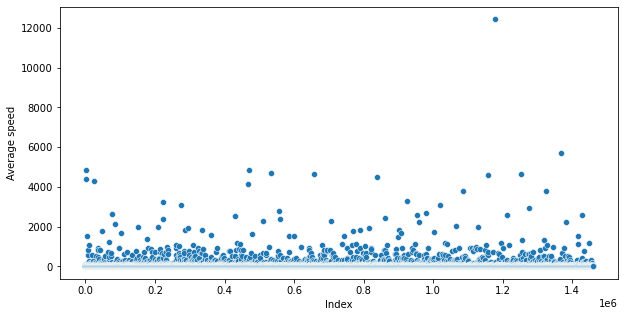

In [25]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [14]:
duration_max = 24 * 3600
speed_max = 300
taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
print(f'По длительности поездки нашлось {taxi_data[(taxi_data.trip_duration > duration_max)].shape[0]} выброса.')
print(f'По признаку скорости нашлось {taxi_data[(taxi_data.avg_speed > speed_max)].shape[0]} выбросов.')
taxi_data = taxi_data[(taxi_data.trip_duration < duration_max) & (taxi_data.avg_speed < speed_max)]

По длительности поездки нашлось 4 выброса.
По признаку скорости нашлось 407 выбросов.


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [15]:
taxi_data['trip_duration_log'] = np.log(taxi_data.loc[:, ('trip_duration')]+1)

C:\Users\Антон\AppData\Local\Temp\ipykernel_3748\773004705.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

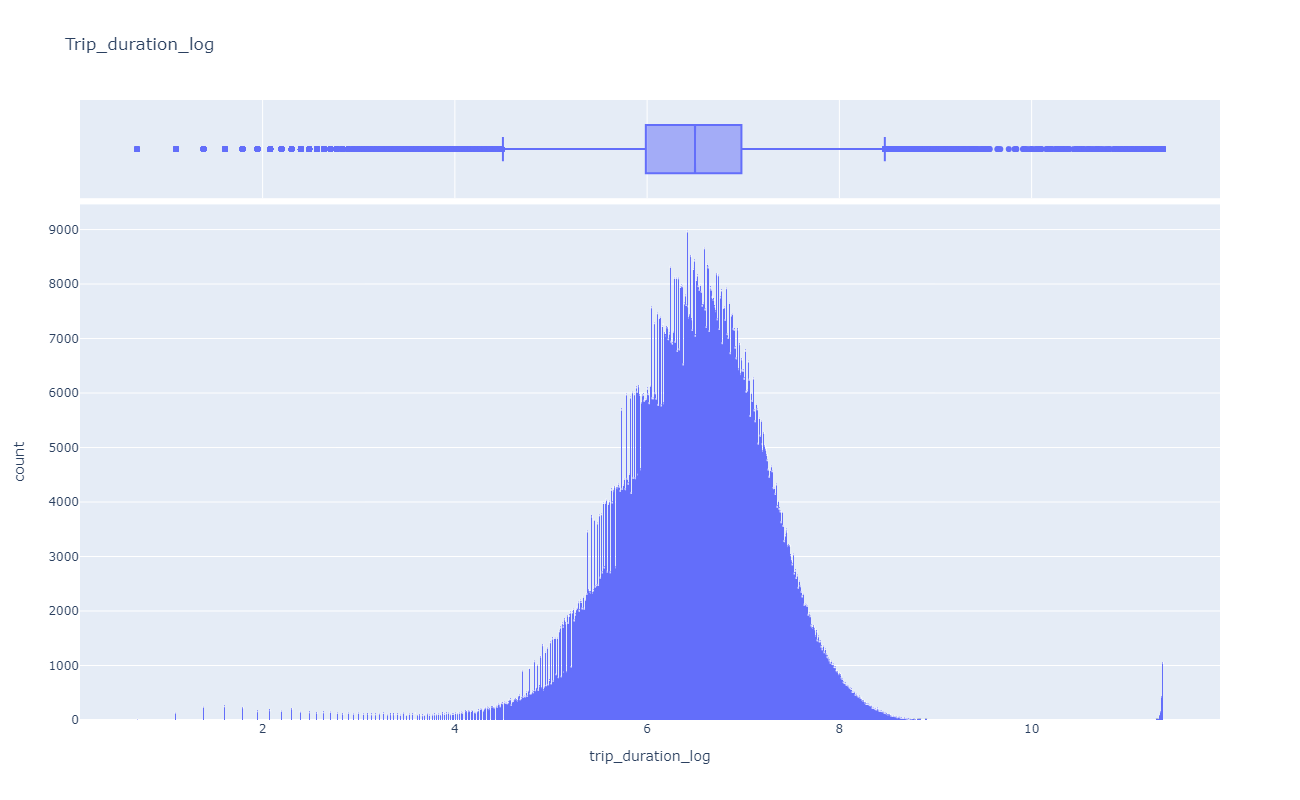

In [5]:
fig = px.histogram(
    data_frame=taxi_data,
    x='trip_duration_log',    
    title='Trip_duration_log',
    text_auto=True,
    marginal='box',
    height=800,    
    width=1300
)
fig.show()

По графику выдвигаем гипотезу, что данные распределены нормально, проверим данную гипотезу тестом на нормальность - Тест Д’Агостино:

In [ ]:
alpha = 0.05

H0 = 'Данные распределены нормально'
H1 = 'Данные не распределены нормально'

_, p_value = stats.normaltest(taxi_data['trip_duration_log'])

print(f'p = {p_value}')

if p_value / 2 > alpha:
    print(H0)    
else:
    print(H1)   

p = 0.0
Данные не распределены нормально


Гипотеза не подтвердилась, данные не распределены нормально.

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

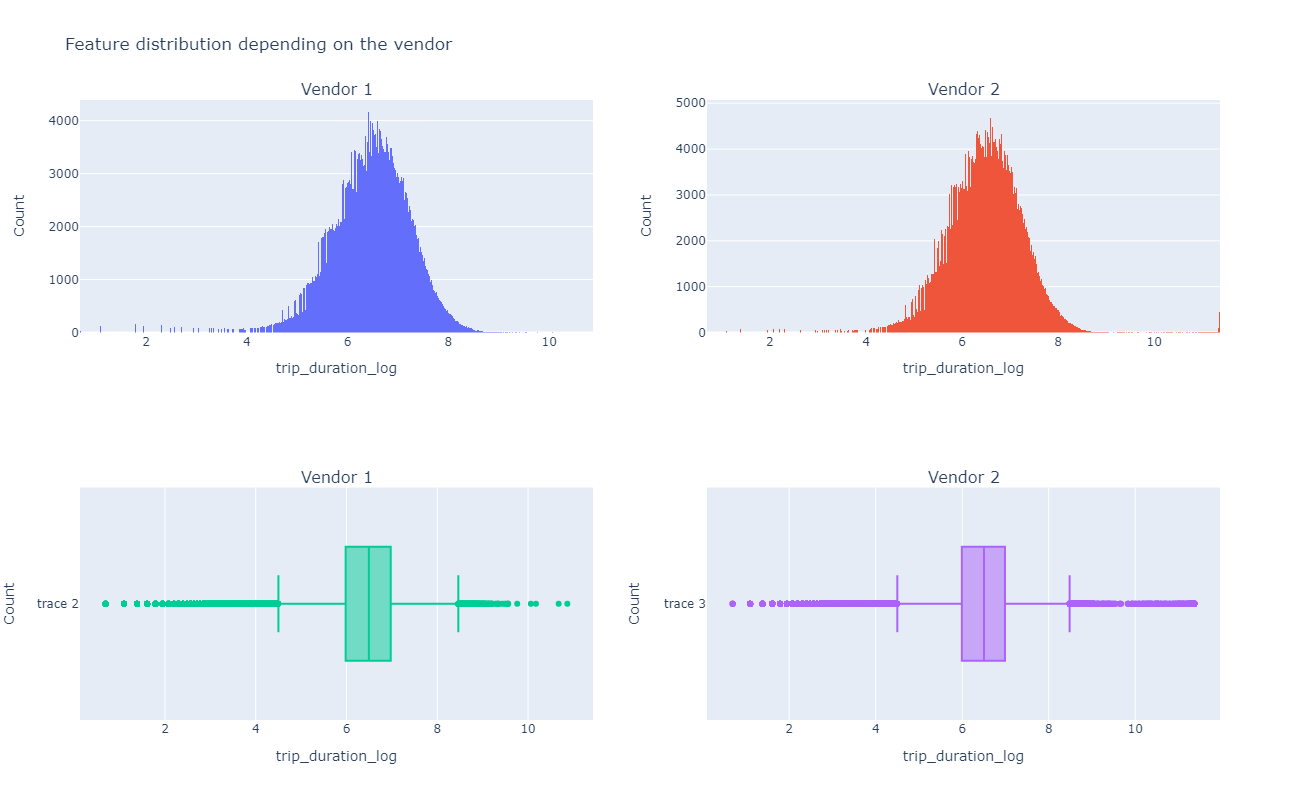

In [7]:
fig = make_subplots(rows=2, cols=2, subplot_titles=['Vendor 1', 'Vendor 2', 'Vendor 1', 'Vendor 2'])

fig.add_trace(go.Histogram(x= taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'], showlegend=False),row=1, col=1)
fig.add_trace(go.Histogram(x= taxi_data[taxi_data['vendor_id']==2]['trip_duration_log'], showlegend=False), row=1, col=2)

fig.add_trace(go.Box(x= taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'], showlegend=False),row=2, col=1)
fig.add_trace(go.Box(x= taxi_data[taxi_data['vendor_id']==2]['trip_duration_log'], showlegend=False), row=2, col=2)

fig.update_layout(height=800, width=1300, title_text='Feature distribution depending on the vendor')
fig.update_xaxes(title='trip_duration_log', col=1, row=1)
fig.update_xaxes(title='trip_duration_log', col=2, row=1)
fig.update_xaxes(title='trip_duration_log', col=1, row=2)
fig.update_xaxes(title='trip_duration_log', col=2, row=2)
fig.update_yaxes(title='Count', col=1, row=1)
fig.update_yaxes(title='Count', col=2, row=1)
fig.update_yaxes(title='Count', col=1, row=2)
fig.update_yaxes(title='Count', col=2, row=2)
fig.show()

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

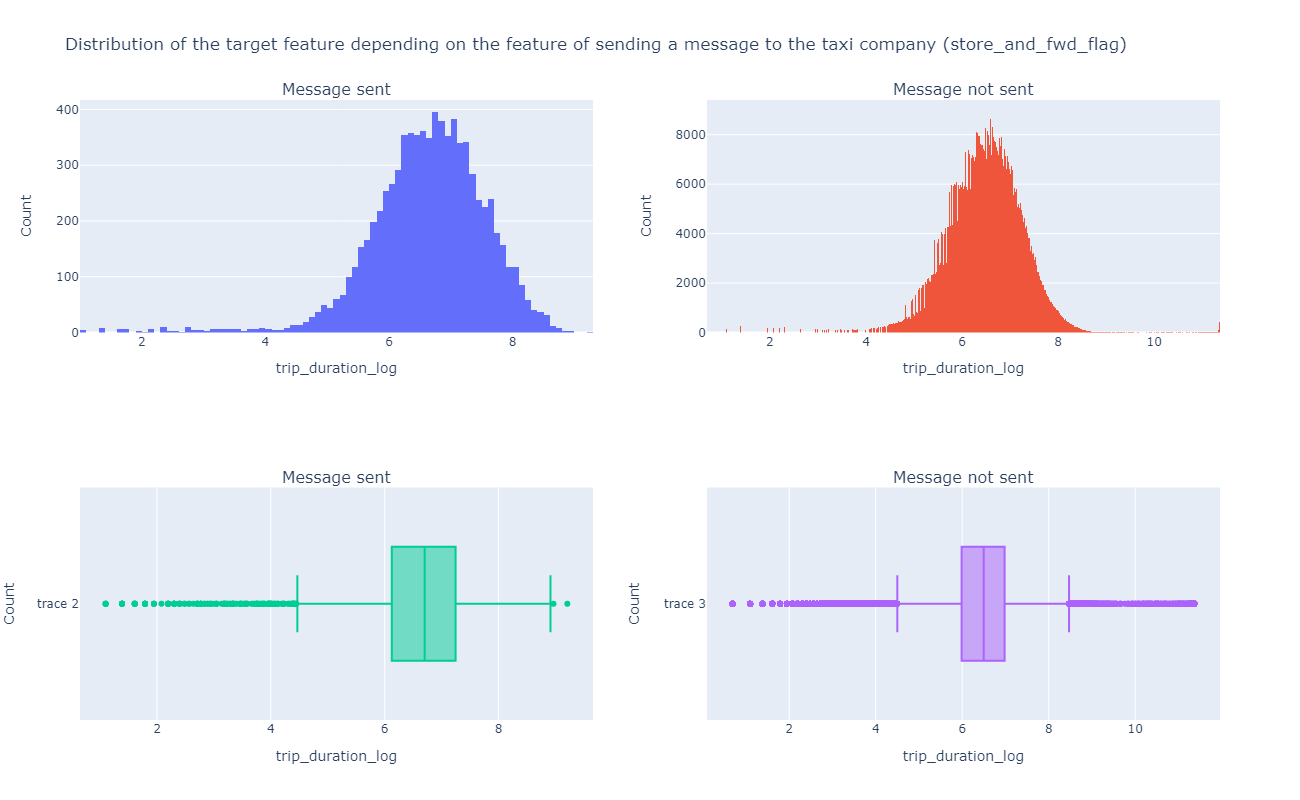

In [9]:
fig = make_subplots(rows=2, cols=2, subplot_titles=['Message sent', 'Message not sent', 'Message sent', 'Message not sent'])

fig.add_trace(go.Histogram(x= taxi_data[taxi_data['store_and_fwd_flag']=='Y']['trip_duration_log'], showlegend=False),row=1, col=1)
fig.add_trace(go.Histogram(x= taxi_data[taxi_data['store_and_fwd_flag']=='N']['trip_duration_log'], showlegend=False), row=1, col=2)

fig.add_trace(go.Box(x= taxi_data[taxi_data['store_and_fwd_flag']=='Y']['trip_duration_log'], showlegend=False),row=2, col=1)
fig.add_trace(go.Box(x= taxi_data[taxi_data['store_and_fwd_flag']=='N']['trip_duration_log'], showlegend=False), row=2, col=2)

fig.update_xaxes(title='trip_duration_log', col=1, row=1)
fig.update_xaxes(title='trip_duration_log', col=2, row=1)
fig.update_xaxes(title='trip_duration_log', col=1, row=2)
fig.update_xaxes(title='trip_duration_log', col=2, row=2)
fig.update_yaxes(title='Count', col=1, row=1)
fig.update_yaxes(title='Count', col=2, row=1)
fig.update_yaxes(title='Count', col=1, row=2)
fig.update_yaxes(title='Count', col=2, row=2)

fig.update_layout(height=800, width=1300, title_text='Distribution of the target feature depending on the feature of sending a message to the taxi company (store_and_fwd_flag)')
fig.show()

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки. Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

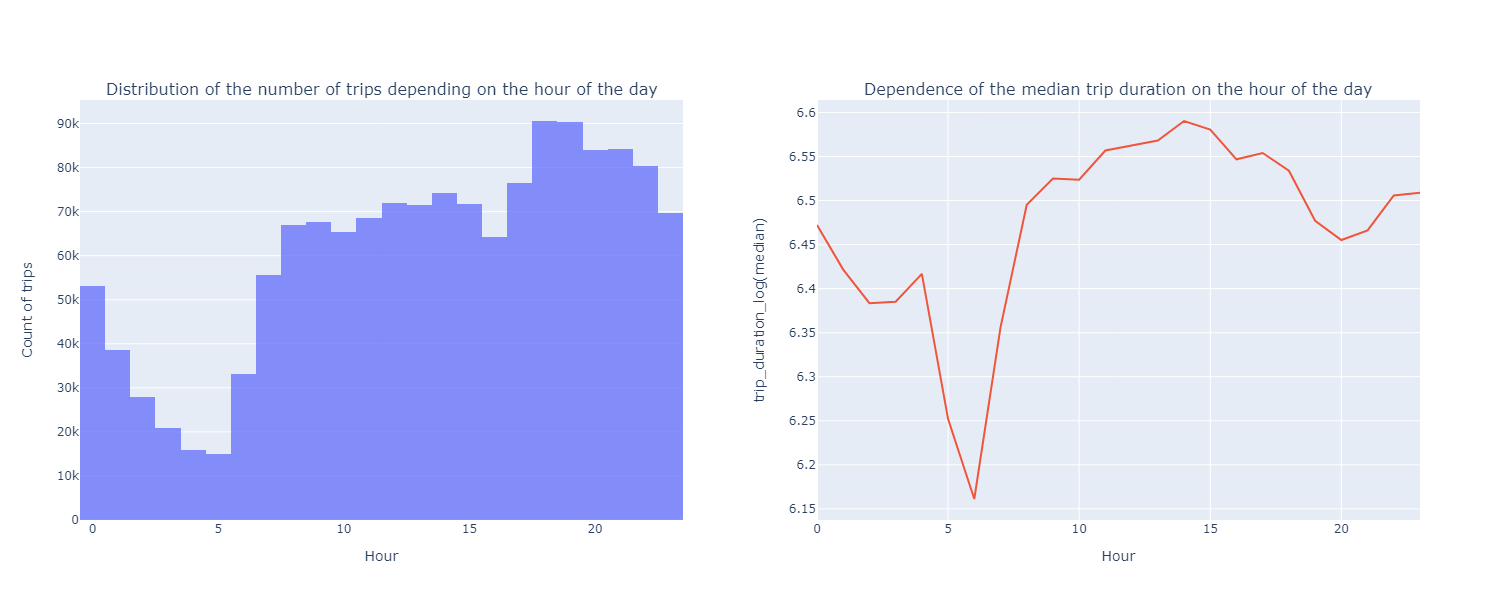

In [10]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Distribution of the number of trips depending on the hour of the day',
                                                    'Dependence of the median trip duration on the hour of the day'])

fig.add_trace(go.Histogram(x= taxi_data['pickup_hour'], opacity=0.75, showlegend=False),row=1, col=1)
fig.add_trace(go.Scatter(x=taxi_data.groupby(['pickup_hour'])['trip_duration_log'].median().index, y=taxi_data.groupby(['pickup_hour'])['trip_duration_log'].median(), showlegend=False), row=1, col=2)

fig.update_layout(height=600, width=1500)
fig.update_xaxes(title='Hour', col=1, row=1)
fig.update_xaxes(title='Hour', col=2, row=1)
fig.update_yaxes(title='Count of trips', col=1, row=1)
fig.update_yaxes(title='trip_duration_log(median)', col=2, row=1)
fig.show()

С 00:00 по 5:00 такси заказыается меньше всего, с 13:00 по 18:00 наблюдается пик медианной длительности поездок.

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


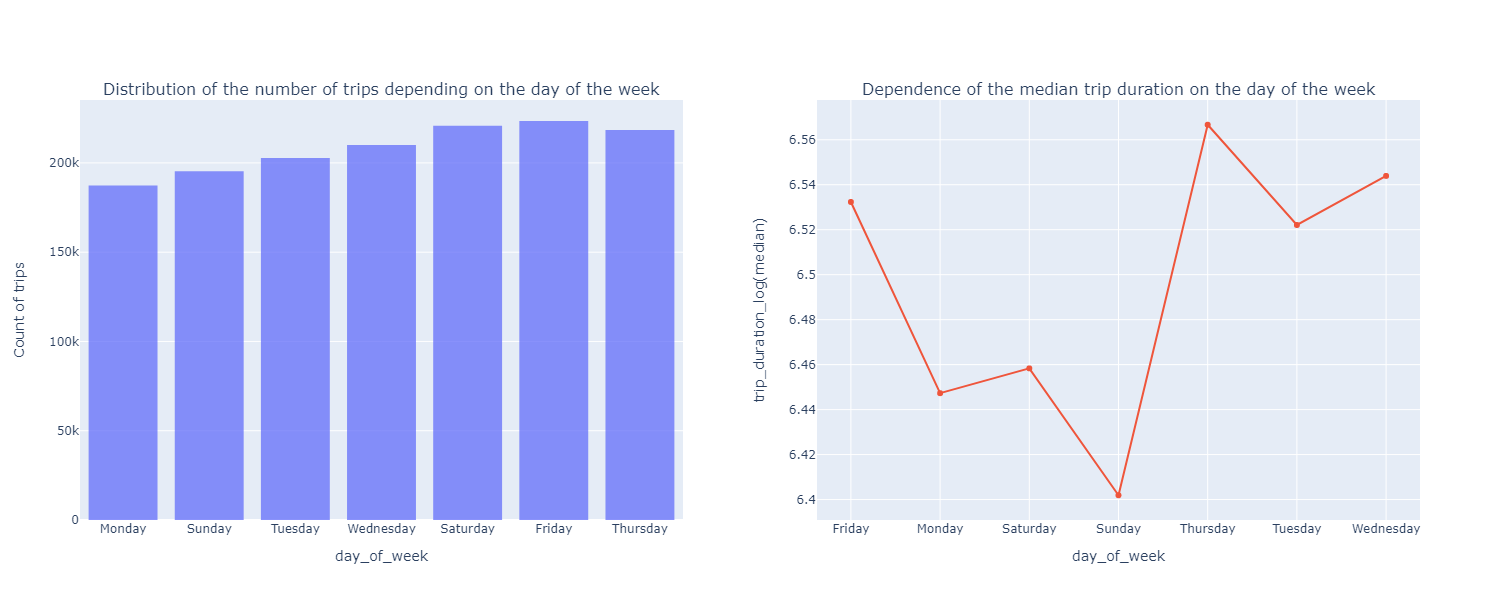

In [11]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Distribution of the number of trips depending on the day of the week',
                                                    'Dependence of the median trip duration on the day of the week'])

fig.add_trace(go.Histogram(x= taxi_data['pickup_day_of_week'], opacity=0.75, showlegend=False),row=1, col=1)
fig.add_trace(go.Scatter(x=taxi_data.groupby(['pickup_day_of_week'])['trip_duration_log'].median().index, y=taxi_data.groupby(['pickup_day_of_week'])['trip_duration_log'].median(), showlegend=False), row=1, col=2)

fig.update_layout(height=600, width=1500)
fig.update_xaxes(title='day_of_week', col=1, row=1)
fig.update_xaxes(title='day_of_week', col=2, row=1)
fig.update_yaxes(title='Count of trips', col=1, row=1)
fig.update_yaxes(title='trip_duration_log(median)', col=2, row=1)

fig.show()

Больше всего совершаетя поездок по пятницам(Friday) , а медианная длительность поездки наименьшая в воскресение, что связано с отсутствием пробок в выходной день.

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

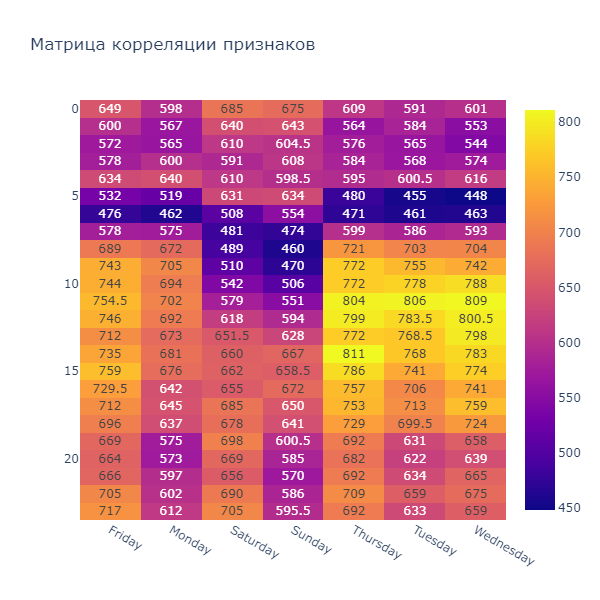

In [12]:
hour_day_week =taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median',
    fill_value=0
)

fig = px.imshow(
    img=hour_day_week.values,
    x=list(hour_day_week.columns),
    y=list(hour_day_week.index),
    text_auto=True,    
    title='Матрица корреляции признаков',
    width=600,
    height=600
    )
fig.show()

Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов. Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  

!!!Внимание!!! 

График **Geographical location of the starting points of trips** [доступен по ссылке](https://github.com/Abricovich/Abricovich-sf_data_science/blob/master/project_9/Geographical%20location%20of%20the%20starting%20points%20of%20trips.PNG)

График **Geographic location of end points** [доступен по ссылке](https://github.com/Abricovich/Abricovich-sf_data_science/blob/master/project_9/Geographic%20location%20of%20end%20points.PNG)


In [16]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

city_start = taxi_data[((taxi_data['pickup_longitude'] >= city_long_border[0]) & (taxi_data['pickup_longitude'] <= city_long_border[1])) & \
    ((taxi_data['pickup_latitude'] >= city_lat_border[0]) & (taxi_data['pickup_latitude'] <= city_lat_border[1]))]
                                

city_fin = taxi_data[((taxi_data['dropoff_longitude'] >= city_long_border[0]) & (taxi_data['dropoff_longitude'] <= city_long_border[1])) & \
    ((taxi_data['dropoff_latitude'] >= city_lat_border[0]) & (taxi_data['dropoff_latitude'] <= city_lat_border[1]))]

In [ ]:
fig = px.scatter(
    data_frame=city_start, # DataFrame
    x='pickup_longitude', # ось абсцисс
    y='pickup_latitude',
    color = 'geo_cluster',
    #labels = {'pickup_longitude': 'Долгота','pickup_latitude': 'Широта'},
    size_max = 1,
    width=1300, # ширина
    height=900, # высота
    title='Geographical location of the starting points of trips' # заголовок
)
fig.show('vscode')

In [ ]:
fig = px.scatter(
    data_frame=city_fin, # DataFrame
    x='dropoff_longitude', # ось абсцисс
    y='dropoff_latitude',
    color = 'geo_cluster',    
    size_max = 1,
    width=1300, # ширина
    height=900, # высота
    title='Geographic location of end points' # заголовок
)
fig.show('vscode')

In [36]:
city_start["geo_cluster"].value_counts()

0    596316
9    382989
4    358401
5     43579
7     40994
3     26990
1      6932
6         4
Name: geo_cluster, dtype: int64

In [37]:
city_fin["geo_cluster"].value_counts()

0    596147
9    376429
4    352615
5     42810
7     40229
3     25560
1      5606
Name: geo_cluster, dtype: int64

Видим, что 2 кластера не попало в выборку - это 8 и 2, в кластерах находилось по 5 и 2 наблюдений соответственно - данные поездки осуществлялись за пределами города.

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [17]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'directon', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'avg_speed', 'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [18]:
train_data = taxi_data.copy()
train_data = train_data.drop('avg_speed', axis=1)
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,directon,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


# Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


- Признак id является уникальным для каждой поездки и не несёт полезной информации в определении её продолжительности
- В наших данных утечку создаёт признак dropoff_datetime — зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки.

In [19]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [20]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [21]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x== 'N' else 1)

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [22]:
feature_onehot = train_data[['pickup_day_of_week', 'geo_cluster', 'events']]
one_code = preprocessing.OneHotEncoder(drop='first')
data = one_code.fit_transform(feature_onehot).toarray()
column_names = one_code.get_feature_names_out()
data_onehot = pd.DataFrame(data, columns=column_names)

Добавим полученную таблицу с закодированными признаками:

In [23]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(feature_onehot, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [24]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [25]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [26]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train_log)
best_features = selector.get_feature_names_out()
best_features

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_Monday',
       'pickup_day_of_week_Saturday', 'pickup_day_of_week_Sunday',
       'pickup_day_of_week_Thursday', 'pickup_day_of_week_Tuesday',
       'pickup_day_of_week_Wednesday', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

In [27]:
X_train = X_train[best_features]
X_valid = X_valid[best_features]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [28]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_valid_scal = scaler.transform(X_valid)

In [16]:
print(f'Среднее арифметическое для певого предиктора валидационной выборке - {round(X_valid_scal[:,0].mean(), 2)}.')

Среднее арифметическое для певого предиктора валидационной выборке - 0.54.


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [53]:
model_lin = linear_model.LinearRegression()
model_lin.fit(X_train_scal, y_train_log)
y_train_pred = model_lin.predict(X_train_scal)
y_test_pred = model_lin.predict(X_valid_scal)

print(f'RMSLE for train - {round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False), 2)}')
print(f'RMSLE for test - {round((metrics.mean_squared_error(y_valid_log, y_test_pred, squared=False)), 2)}')

RMSLE for train - 0.54
RMSLE for test - 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

poly.fit(X_train_scal)
X_train_poly = poly.transform(X_train_scal)
X_valid_poly = poly.transform(X_valid_scal)

model_lin_poly = linear_model.LinearRegression()
model_lin_poly.fit(X_train_poly, y_train_log)
y_train_pred = model_lin_poly.predict(X_train_poly)
y_test_pred = model_lin_poly.predict(X_valid_poly)

print(f'RMSLE for train - {round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False), 2)}')
print(f'RMSLE for test - {round((metrics.mean_squared_error(y_valid_log, y_test_pred, squared=False)), 2)}')


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
model_poly_l2 = linear_model.Ridge(alpha=1)

model_poly_l2.fit(X_train_poly, y_train_log)
y_train_pred = model_poly_l2.predict(X_train_poly)
y_test_pred = model_poly_l2.predict(X_valid_poly)

print(f'RMSLE for train - {round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False), 2)}')
print(f'RMSLE for test - {round((metrics.mean_squared_error(y_valid_log, y_test_pred, squared=False)), 2)}')

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [54]:
tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train_scal, y_train_log)

y_train_pred = tree_model.predict(X_train_scal)
y_test_pred = tree_model.predict(X_valid_scal)

print(f'RMSLE for train - {round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False), 2)}')
print(f'RMSLE for test - {round((metrics.mean_squared_error(y_valid_log, y_test_pred, squared=False)), 2)}')

RMSLE for train - 0.0
RMSLE for test - 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [17]:
max_depths = range(7, 20)

def tree_depths(X_train, X_test, y_train, y_test):
  RMSLE_train = []
  RMSLE_test = []
  for depth in max_depths:
    tree_model = tree.DecisionTreeRegressor(max_depth=depth, random_state=42).fit(X_train, y_train)
    y_train_pred = tree_model.predict(X_train)
    y_test_pred = tree_model.predict(X_test)
    RMSLE_tr = round(metrics.mean_squared_error(y_train, y_train_pred, squared=False), 2)
    RMSLE_tes = round((metrics.mean_squared_error(y_test, y_test_pred, squared=False)), 2)
    RMSLE_train.append(RMSLE_tr)
    RMSLE_test.append(RMSLE_tes)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(max_depths), y=RMSLE_train, name='Train'))
  fig.add_trace(go.Scatter(x=list(max_depths), y=RMSLE_test, name='Valid'))
  fig.update_xaxes(title='Depth count')
  fig.update_yaxes(title='RMSLE')
  fig.update_layout(title='Dependence of RMSLE on the number of trees', height=600, width=800)
  return fig.show()

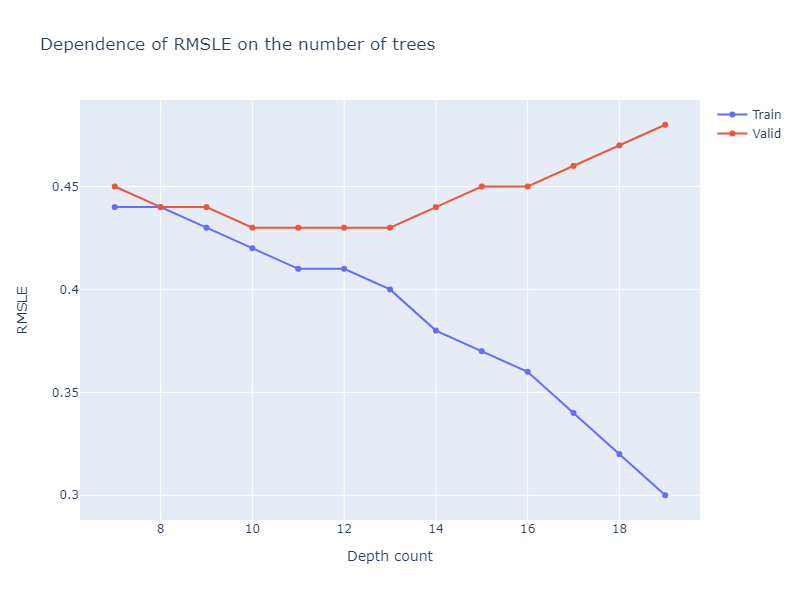

In [18]:
tree_depths(X_train_scal, X_valid_scal, y_train_log, y_valid_log)

In [60]:
tree_model = tree.DecisionTreeRegressor(max_depth=12)
tree_model.fit(X_train_scal, y_train_log)

y_train_pred = tree_model.predict(X_train_scal)
y_test_pred = tree_model.predict(X_valid_scal)

print(f'RMSLE for train - {round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False), 2)}')
print(f'RMSLE for test - {round((metrics.mean_squared_error(y_valid_log, y_test_pred, squared=False)), 2)}')

RMSLE for train - 0.41
RMSLE for test - 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [62]:
random_forest = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=12,
                                               min_samples_split=20,
                                               criterion='squared_error',
                                               random_state=42)

random_forest.fit(X_train_scal, y_train_log)

y_train_pred = random_forest.predict(X_train_scal)
y_test_pred = random_forest.predict(X_valid_scal)

print(f'RMSLE for train - {round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False), 2)}')
print(f'RMSLE for test - {round((metrics.mean_squared_error(y_valid_log, y_test_pred, squared=False)), 2)}')


RMSLE for train - 0.4
RMSLE for test - 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [31]:
gb_model = ensemble.GradientBoostingRegressor(n_estimators=100,
                                              max_depth=6,
                                              min_samples_split=30,
                                              learning_rate=0.5,
                                              random_state=42)

gb_model.fit(X_train_scal, y_train_log)

y_train_pred = gb_model.predict(X_train_scal)
y_test_pred = gb_model.predict(X_valid_scal)

print(f'RMSLE for train - {round(metrics.mean_squared_error(y_train_log, y_train_pred, squared=False), 2)}')
print(f'RMSLE for test - {round((metrics.mean_squared_error(y_valid_log, y_test_pred, squared=False)), 2)}')

RMSLE for train - 0.37
RMSLE for test - 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


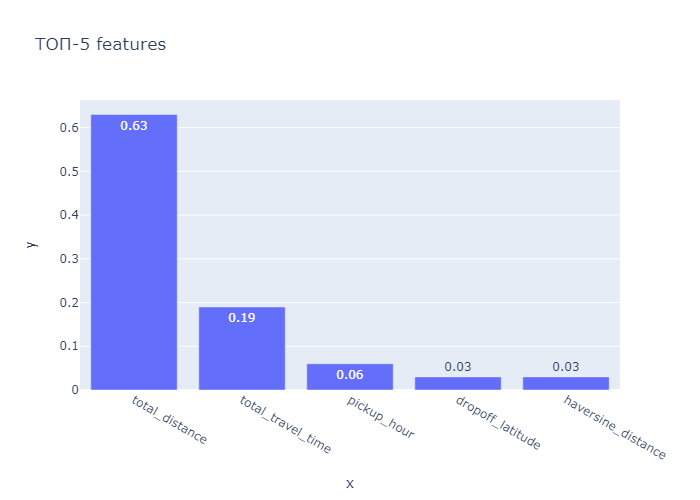

In [20]:
gb_feat = pd.DataFrame([gb_model.feature_importances_], columns=X_train.columns)
fig = px.bar(x = list(gb_feat.loc[0].sort_values(ascending=False)[0:5].index),
    y=round(gb_feat.loc[0].sort_values(ascending=False)[0:5], 2),
    text_auto=True,
    title='ТОП-5 features'    
)
fig.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [73]:
y_valid = np.exp(y_valid_log) - 1
y_test_pred_conv = np.exp(y_test_pred) - 1

print(f'MeAE for valid = {round(metrics.median_absolute_error(y_valid, y_test_pred_conv) / 60, 1)}.')

MeAE for valid = 1.8.


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных(доступен по [ссылке](https://drive.google.com/file/d/1XLglRxmQk3b7y1X3XNm7gQiUu4Ln0frl/view?usp=share_link)), он нам еще пригодится.

Файл OSRM для тестового набора доступен по [ссылке](https://drive.google.com/file/d/1MR1wr-ifJtcJgralgYCIPB3Jgqr71EsN/view?usp=share_link).


In [29]:
test_data = pd.read_csv("Project5_test_data.zip")
osrm_data_test = pd.read_csv("Project5_osrm_data_test.zip")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [30]:
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)

coords = np.hstack((test_data[['pickup_latitude', 'pickup_longitude']],
                    test_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
feature_onehot = test_data[['pickup_day_of_week', 'geo_cluster', 'events']]
test_data_onehot = one_code.fit_transform(feature_onehot).toarray()
column_names = one_code.get_feature_names_out()
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(feature_onehot, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [39]:
y_test_predict = np.exp(gb_model.predict(X_test_scaled)) - 1

In [41]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)

Файл submission доступен по [ссылке](https://drive.google.com/file/d/10RpczyblbkdRnNyadN1XE6t3JxvTr9Sc/view?usp=share_link)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [42]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [43]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scal, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scal, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [44]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93576	valid-rmse:1.93572
[20]	train-rmse:0.78510	valid-rmse:0.78595
[30]	train-rmse:0.47863	valid-rmse:0.48067
[40]	train-rmse:0.42062	valid-rmse:0.42332
[50]	train-rmse:0.40902	valid-rmse:0.41217
[60]	train-rmse:0.40392	valid-rmse:0.40740
[70]	train-rmse:0.40094	valid-rmse:0.40482
[80]	train-rmse:0.39878	valid-rmse:0.40296
[90]	train-rmse:0.39718	valid-rmse:0.40163
[100]	train-rmse:0.39565	valid-rmse:0.40033
[110]	train-rmse:0.39437	valid-rmse:0.39930
[120]	train-rmse:0.39314	valid-rmse:0.39848
[130]	train-rmse:0.39198	valid-rmse:0.39751
[140]	train-rmse:0.39085	valid-rmse:0.39687
[150]	train-rmse:0.38996	valid-rmse:0.39643
[160]	train-rmse:0.38920	valid-rmse:0.39589
[170]	train-rmse:0.38810	valid-rmse:0.39507
[180]	train-rmse:0.38727	valid-rmse:0.39451
[190]	train-rmse:0.38656	valid-rmse:0.39411
[200]	train-rmse:0.38575	valid-rmse:0.39356
[210]	train-rmse:0.38498	valid-rmse:0.39308
[220]	train-rmse:0.38442	valid-rmse:0.39283

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [45]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39095


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

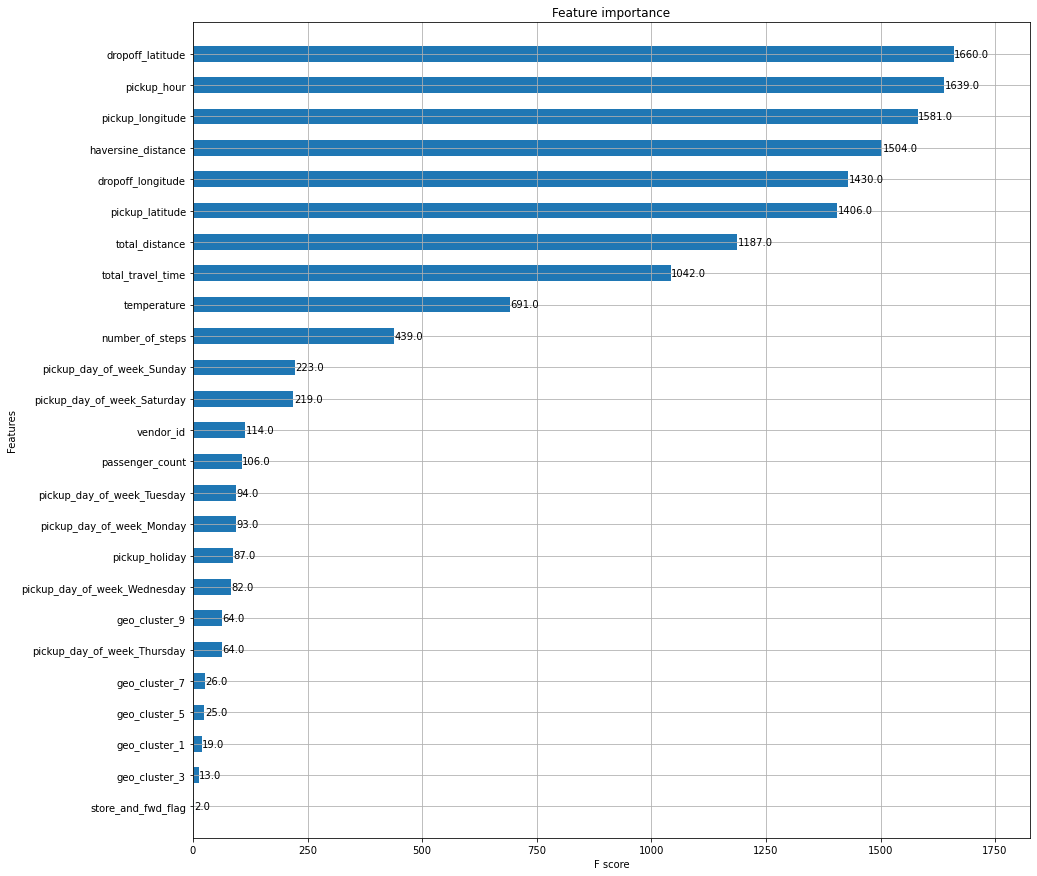

In [46]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)